In [3]:
!pip install genaibook

In [4]:
import torch
from diffusers import DDPMPipeline

from genaibook.core import get_device

# Set the device to use our GPU or CPU
device = get_device()

# Load the pipeline
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256") #Trainde on high-quality celebrity datasets
image_pipe.to(device)

# Sample an image
image_pipe().images[0]

Loading pipeline components...:  50%|█████     | 1/2 [00:00<00:00,  9.95it/s]An error occurred while trying to fetch /Users/vlzqz/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/vlzqz/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
 16%|█▋        | 164/1000 [02:21<12:00,  1.16it/s]


KeyboardInterrupt: 

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


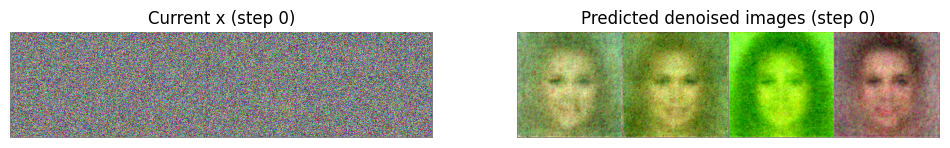

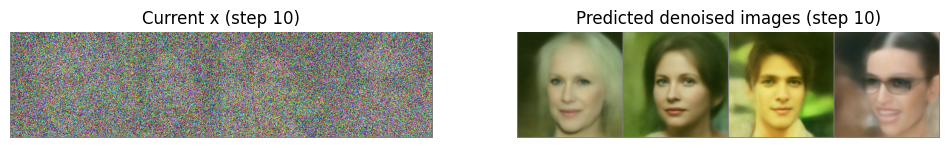

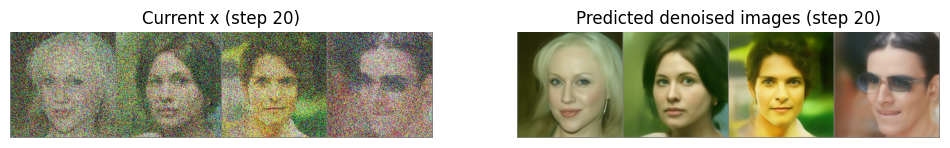

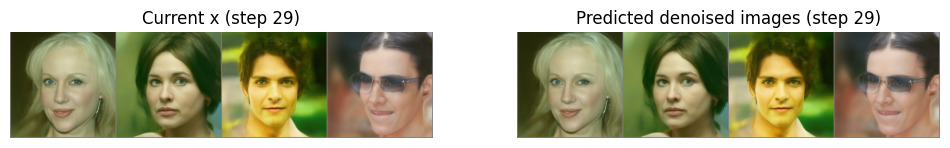

In [ ]:
from genaibook.core import plot_noise_and_denoise
import torch
from diffusers import DDPMPipeline
# The random starting point is a batch of 4 images

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the pipeline
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

# Each image is 3-channel (RGB) 256x256 pixel image
image = torch.randn(4, 3, 256, 256).to(device)



# Set the specific number of diffusion steps
image_pipe.scheduler.set_timesteps(num_inference_steps=30)

# Loop through the sampling timesteps
for i, t in enumerate(image_pipe.scheduler.timesteps):
    # Get the prediction given the current sample x and the timestep t
    # As we're running inference, we don't need to calculate gradients,
    # so we can use torch.inference_mode().
    with torch.inference_mode():
        # We need to pass in the timestep t so that the model knows what
        # timestep it's currently at. We'll learn more about this in the
        # coming sections.
        noise_pred = image_pipe.unet(image, t)["sample"]

    # Calculate what the updated x should look like with the scheduler
    scheduler_output = image_pipe.scheduler.step(noise_pred, t, image)

    # Update x
    image = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(image_pipe.scheduler.timesteps) - 1:
        plot_noise_and_denoise(scheduler_output, i)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
from torchvision import transforms

image_size = 64

# Define transformations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

In [ ]:
def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


dataset.set_transform(transform)
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

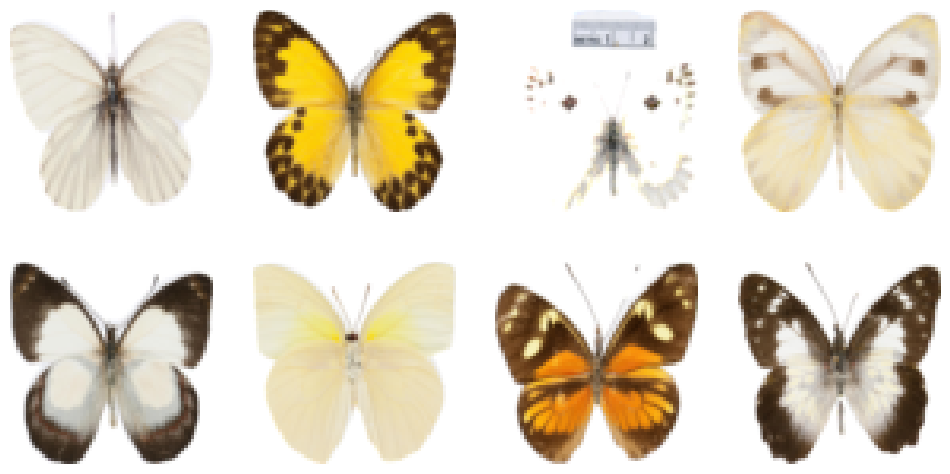

In [ ]:
from genaibook.core import show_images

batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
show_images(batch["images"][:8] * 0.5 + 0.5)

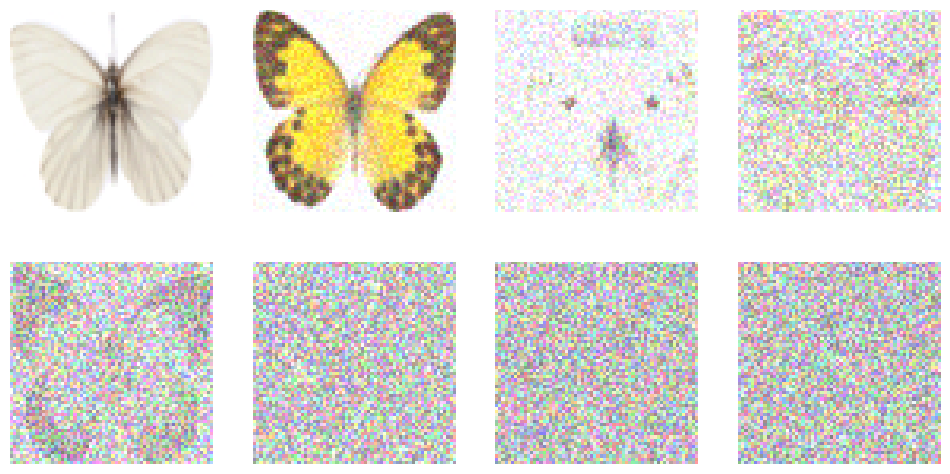

In [ ]:
from diffusers import DDPMScheduler

# We'll learn about beta_start and beta_end in the next sections
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
x = batch["images"][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=3,  # 3 channels for RGB images
    sample_size=64,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

# Pass a batch of data through to make sure it works
with torch.inference_mode():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample

print(noised_x.shape)
print(out.shape)

torch.Size([8, 3, 64, 64])
torch.Size([8, 3, 64, 64])


In [ ]:
from torch.nn import functional as F

num_epochs = 50  # How many runs through the data should we do?
lr = 1e-4  # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model (this takes a while)
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # Add noise to the clean images according
        # to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        # The model also uses the timestep as an input
        # for additional conditioning
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Store the loss for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

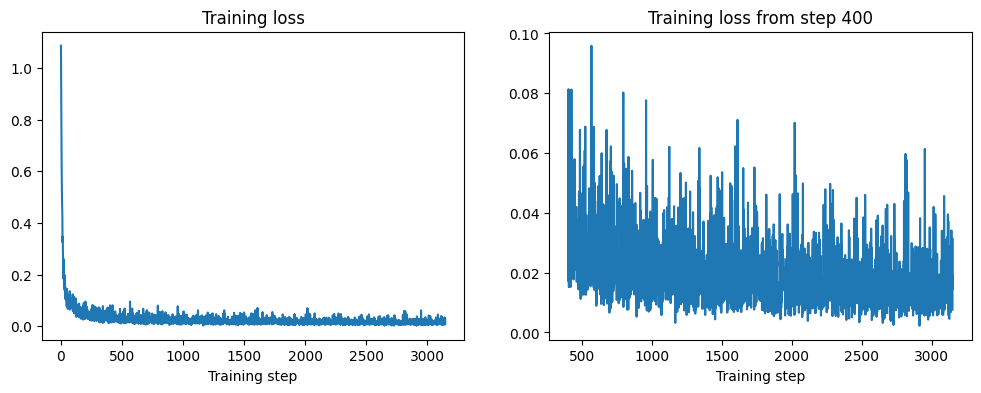

In [ ]:
from matplotlib import pyplot as plt

plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

  0%|          | 0/1000 [00:00<?, ?it/s]

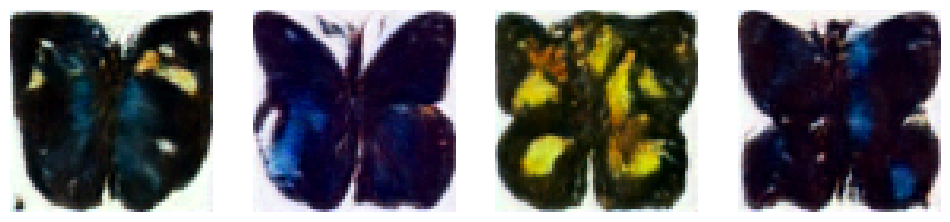

In [ ]:
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images
show_images(ims, nrows=1)

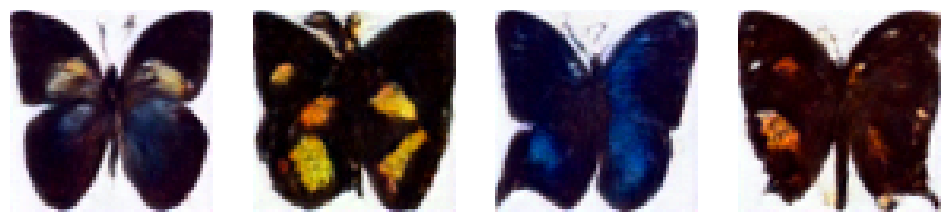

In [ ]:
# Random starting point (4 random images):
sample = torch.randn(4, 3, 64, 64).to(device)

for t in scheduler.timesteps:
    # Get the model prediction
    with torch.inference_mode():
        noise_pred = model(sample, t)["sample"]

    # Update sample with step
    sample = scheduler.step(noise_pred, t, sample).prev_sample

show_images(sample.clip(-1, 1) * 0.5 + 0.5, nrows=1)